## Generalization from unimodal to multimodal
Population decoding of the object identity by training with unimodal trials (visual or auditory) and testing with multimodal trials.

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import random

from scipy import stats
import statsmodels.api as sm

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns

from datetime import date
import time

from joblib import Parallel, delayed

import h5py

In [2]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
mother_path = Path('D:/Multi-modal project/')

save_path = mother_path / 'analysis' / 'result' / '7. Population decoding'
os.makedirs(save_path,exist_ok=True)

fig_path = mother_path / 'analysis' / 'result' / 'figures'
os.makedirs(fig_path,exist_ok=True)

### Parameter setting

In [4]:
# colors for multimodal, vis-only, aud-only conditions
color = ['tab:purple','tab:blue','tab:red','tab:green']
color2 = ['cyan','magenta','gray']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [5]:
cell_path = mother_path/'analysis'/'result'/'zFR export'/'13-Jun-2023'
cell_list = os.listdir(cell_path)

# load hdf5 files containing shuffled results
data_path = mother_path /'analysis'/'result'/'3. ANOVA'/'2023-07-10'
data2_path = mother_path /'analysis'/'result'/'3.1 Multiple linear regression'/'2023-07-10'
f = h5py.File(data_path/'2023-07-10_ANOVA_result.hdf5','r')
f2 = h5py.File(data2_path/'2023-07-10_multiple_regression_result.hdf5','r')

In [6]:
def h5_to_df(f):
    keys = list(f.keys())
    attributes = {}
    
    for key in keys:
        attributes[key] = dict(f[key].attrs.items())
    
    df = pd.DataFrame.from_dict(attributes, orient='index')
    df.index.name = 'key'
    df = df.reset_index()
    
    return df

In [7]:
df = h5_to_df(f)
df = df[df['region']=='PER']
df.reset_index(inplace=True, drop=True)

for key in df['key']:
    if df.loc[df['key']==key, 'object cell'].item() == 0:
        df.loc[df['key']==key, 'category'] = 'none'
    else:
        if f2[key].attrs['response cell'] == 0:
            df.loc[df['key']==key, 'category'] = 'object'
        else:
            df.loc[df['key']==key, 'category'] = 'response'

## Cross-modal decoding

In [8]:
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [34]:
def subsample_cross(df, rat, num_trial, bin_size, time_bin, shuffle):
    scaler = StandardScaler()
    
    num_bin = int(90/bin_size)
    object_cell_list = df.loc[(df['rat']==rat)&(df['category']=='object'),'key'].to_numpy()
    
    # M by N array of subsampled firing rates
    # M = stimulus condition * number of subsampled trials
    # N = number of cells * number of time bins
    X = np.zeros((6*num_trial, len(object_cell_list)*time_bin))
    
    for i,cell_key in enumerate(object_cell_list):
    
        # load trial-by-trial firing rate data of a cell
        key = cell_key.zfill(4)
        cell_filename = list(cell_path.glob(f'{key}*.csv'))
        df_cell = pd.read_csv(cell_filename[0])
        df_cell.drop(df_cell[df_cell.Correctness==0].index,inplace=True)
        df_cell.reset_index(inplace=True,drop=True)
        
        # goal location (left or right) of each object condition
        boy_goal = df_cell.loc[df_cell['Visual']=='Boy','RWD_Loc'].values[0]
        egg_goal = df_cell.loc[df_cell['Visual']=='Egg','RWD_Loc'].values[0]
        
        # shuffling stimulus condition for permutation test
        if shuffle:
            cond_array = df_cell[['Type','RWD_Loc']].to_numpy()
            shuffled_cond_array = np.random.permutation(cond_array)
            df_cell[['Type','RWD_Loc']] = shuffled_cond_array

        # stimulus condition (identity x modality)
        cond = [(df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==egg_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==egg_goal),                
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==egg_goal)]

        fr_id = df_cell.columns.get_loc('Var10')  # get the index of the first firing rate column
        FR = df_cell.iloc[:,fr_id:].to_numpy()    # convert firing rate data to numpy array
    
        # recalculate mean firing rates of each time bin
        FR_bin = np.zeros((len(df_cell),time_bin))
        for b in range(time_bin):
            FR_bin[:,b] = FR[:,b*time_bin:(b+1)*time_bin].mean(axis=1)

        for c in range(len(cond)):
            # subsample n trials from each stimulus condition
            subsampled_trial = df_cell[cond[c]].sample(num_trial).index
            # firing rates of subsampled trials
            FR_sub = FR_bin[subsampled_trial,:]
            # add subsampled firing rate data to the result array
            X[num_trial*c:num_trial*(c+1), time_bin*i:time_bin*(i+1)] = FR_sub

        X_norm = scaler.fit_transform(X)
    
    return X_norm

In [81]:
def subsample_crossmodal_predict(df, model, rat, num_trial, bin_size, time_bin, shuffle):

    result = np.zeros((2,2))

    X = subsample_cross(df, rat, num_trial, bin_size, time_bin, shuffle)

    X_multi = X[:10,:]
    Y_multi = np.repeat(np.arange(2), 5)
    
    X_uni = X[10:,:]
    Y_uni = np.concatenate((np.zeros(5), np.ones(5), np.zeros(5), np.ones(5)))

    # train with visual and test with auditory
    model.fit(X_uni,Y_uni)
    pred = model.predict(X_multi)

    for j in range(len(pred)):
        result[Y_multi[j],int(pred[j])] += 1

    return result

#### SVM parameter

In [67]:
final_model = svm.SVC(kernel='linear', C=0.01)
kfold = 5
num_trial = 5
bin_size = 10
num_iter = 100
rat_list = ['600', '602', '640', '647', '699']

#### Real data

In [114]:
%%time
for t in range(9):
    bin_loop_start = time.time()

    svm_real = np.zeros((len(rat_list),2,2))
    for i,rat in enumerate(rat_list):
        loop_start = time.time()

        rat_result = Parallel(n_jobs=-1)(delayed(subsample_crossmodal_predict)(df, final_model, rat, num_trial, bin_size, t+1, 0) for j in range(num_iter))   

        svm_real[i,:,:] = np.sum(rat_result,axis=0)/(num_iter*10)

        loop_end = time.time()
        loop_time = divmod(loop_end-loop_start,60)
        print(f'LE{rat} completed /// Elapsed time: {int(loop_time[0])} min {loop_time[1]:.2f} sec')

    np.save(save_path / f'{today}_{bin_size*10}ms_{t+1}bins_{num_iter}iter_crossmodal_real.npy',svm_real)

    bin_loop_end = time.time()
    bin_loop_time = divmod(bin_loop_end-bin_loop_start,60)
    print('---------------------------------------------------')
    print(f'{t+1} timebin completed / Elapsed time: {int(bin_loop_time[0])} min {bin_loop_time[1]:.2f} sec')
    print('===================================================')
    print('')    

LE600 completed /// Elapsed time: 0 min 19.72 sec
LE602 completed /// Elapsed time: 0 min 31.97 sec
LE640 completed /// Elapsed time: 0 min 16.13 sec
LE647 completed /// Elapsed time: 0 min 14.96 sec
LE699 completed /// Elapsed time: 0 min 19.40 sec
---------------------------------------------------
1 timebin completed / Elapsed time: 1 min 42.19 sec

LE600 completed /// Elapsed time: 0 min 17.81 sec
LE602 completed /// Elapsed time: 0 min 30.80 sec
LE640 completed /// Elapsed time: 0 min 17.31 sec
LE647 completed /// Elapsed time: 0 min 16.27 sec
LE699 completed /// Elapsed time: 0 min 16.67 sec
---------------------------------------------------
2 timebin completed / Elapsed time: 1 min 38.87 sec

LE600 completed /// Elapsed time: 0 min 13.40 sec
LE602 completed /// Elapsed time: 0 min 36.31 sec
LE640 completed /// Elapsed time: 0 min 20.88 sec
LE647 completed /// Elapsed time: 0 min 15.96 sec
LE699 completed /// Elapsed time: 0 min 21.23 sec
----------------------------------------

#### Shuffle data

In [223]:
%%time
num_shuffle = 1000

for t in range(9):
    bin_loop_start = time.time()
    
    svm_shuffle_result = np.zeros((num_shuffle,len(rat_list),2,2))
    for shuffle_run in range(num_shuffle):
        
        # measure elapsed time for every 100 loops
        if divmod(shuffle_run+1,100)[1] == 1:
            loop_start = time.time()
            
        svm_result = np.zeros((len(rat_list),2,2))
        for r,rat in enumerate(rat_list):
            rat_result = Parallel(n_jobs=-1)(delayed(subsample_crossmodal_predict)(df, final_model, rat, num_trial, bin_size, t+1, 1) for j in range(num_iter))
            
            svm_result[r,:,:] = np.sum(rat_result,axis=0)/(num_iter*10)

        svm_shuffle_result[shuffle_run,:,:,:] = svm_result
    
        # measure elapsed time for every 100 loops
        if divmod(shuffle_run+1,100)[1] == 0:
            loop_end = time.time()
            loop_time = divmod(loop_end-loop_start,60)
            print(f'Shuffle run {shuffle_run+1} completed /// Elapsed time: {int(loop_time[0])} min {loop_time[1]:.2f} sec')

    np.save(save_path / f'{today}_{bin_size*10}ms_{t+1}bins_{num_iter}iter_crossmodal_shuffle.npy',svm_shuffle_result)

    bin_loop_end = time.time()
    bin_loop_time = divmod(bin_loop_end-bin_loop_start,60)
    print('---------------------------------------------------')
    print(f'{t+1} timebin completed / Elapsed time: {int(bin_loop_time[0])} min {bin_loop_time[1]:.2f} sec')
    print('===================================================')
    print('')

Shuffle run 100 completed /// Elapsed time: 21 min 43.31 sec
Shuffle run 200 completed /// Elapsed time: 21 min 19.85 sec
Shuffle run 300 completed /// Elapsed time: 21 min 17.53 sec
Shuffle run 400 completed /// Elapsed time: 21 min 19.73 sec
Shuffle run 500 completed /// Elapsed time: 21 min 25.52 sec
Shuffle run 600 completed /// Elapsed time: 21 min 13.73 sec
Shuffle run 700 completed /// Elapsed time: 21 min 15.45 sec
Shuffle run 800 completed /// Elapsed time: 21 min 19.24 sec
Shuffle run 900 completed /// Elapsed time: 21 min 16.72 sec
Shuffle run 1000 completed /// Elapsed time: 21 min 15.75 sec
---------------------------------------------------
1 timebin completed / Elapsed time: 213 min 27.32 sec

Shuffle run 100 completed /// Elapsed time: 21 min 19.14 sec
Shuffle run 200 completed /// Elapsed time: 21 min 18.85 sec
Shuffle run 300 completed /// Elapsed time: 21 min 19.34 sec
Shuffle run 400 completed /// Elapsed time: 21 min 20.57 sec
Shuffle run 500 completed /// Elapsed 

#### Evaluating decoding results

In [119]:
load_date = '2023-07-31'

real_data = np.load(save_path / 'crossmodal' / f'{load_date}_{bin_size*10}ms_{9}bins_{num_iter}iter_crossmodal_real.npy')
shuffle_data = np.load(save_path / 'crossmodal' / f'{load_date}_{bin_size*10}ms_{9}bins_{num_iter}iter_crossmodal_shuffle.npy')

real_mean = np.mean(real_data, axis=0)
shuffle_mean = np.mean(shuffle_data, axis=1)

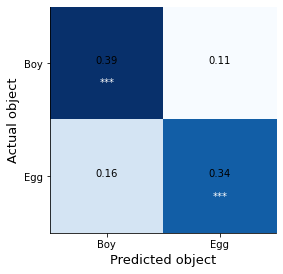

In [124]:
# contingency matrix for data using all time bins
fig,ax = plt.subplots(figsize=(4,4))

ax.imshow(real_mean[:,:], cmap=plt.cm.get_cmap('Blues'));

t = ['Visual to Auditory', 'Auditory to Visual']
for m in range(2):
    for l in range(2):
        ax.text(m,l,'{:.2f}'.format(real_mean[l,m]),ha='center')
        pval_crit = [np.percentile(shuffle_mean[:,l,m],95), np.percentile(shuffle_mean[:,l,m],99),
                     np.percentile(shuffle_mean[:,l,m],99.9)]
        if real_mean[l,m] > pval_crit[2]:
            ax.text(m,l+0.2,'***', ha='center', color='white')
        elif real_mean[l,m] > pval_crit[1]:
            ax.text(m,l+0.2,'**', ha='center', color='white')
        elif real_mean[l,m] > pval_crit[0]:
            ax.text(m,l+0.2,'*', ha='center', color='white')

    ax.set_xlabel('Predicted object', fontsize=13)
    ax.set_ylabel('Actual object', fontsize=13)
    ax.set_xticks(np.arange(0,2))
    ax.set_xticklabels(['Boy', 'Egg']);
    ax.set_yticks(np.arange(0,2))
    ax.set_yticklabels(['Boy', 'Egg']);

plt.tight_layout()

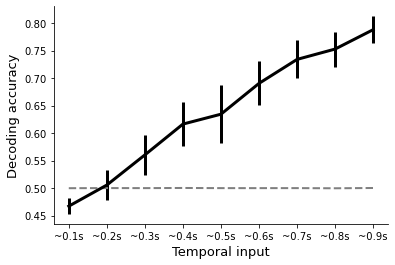

In [139]:
# decoding performance of models using different time range

result = np.zeros((5,9))    # modality * rat * timebin
result_shuffle = np.zeros((5,9))    # modality * rat * timebin

for t in range(9):
    real_data = np.load(save_path / 'crossmodal' / f'{load_date}_{bin_size*10}ms_{t+1}bins_{num_iter}iter_crossmodal_real.npy')
    shuffle_data = np.load(save_path / 'crossmodal' / f'{load_date}_{bin_size*10}ms_{t+1}bins_{num_iter}iter_crossmodal_shuffle.npy')
    shuffle_mean = np.mean(shuffle_data, axis=0)

    result[:,t] = real_data[:,0,0] + real_data[:,0,0]
    result_shuffle[:,t] = shuffle_mean[:,0,0,0] + shuffle_mean[:,0,1,1]

mean_real = np.mean(result, axis=0)
sem_real = stats.sem(result, axis=0)
mean_shuffle = np.mean(result_shuffle, axis=0)

fig,ax = plt.subplots(figsize=(6,4))

ax.errorbar(range(9),mean_real,yerr=sem_real, color='black', linewidth=3)
ax.plot(mean_shuffle, color='tab:gray', linestyle='--', linewidth=2)

ax.set_xticks(range(9));
ax.set_xticklabels(['~0.1s', '~0.2s', '~0.3s', '~0.4s', '~0.5s', '~0.6s', '~0.7s', '~0.8s', '~0.9s']);
#ax.set_yticks(np.arange(0.1,0.6,0.1));
ax.set_xlabel('Temporal input', fontsize=13);
ax.set_ylabel('Decoding accuracy', fontsize=13);